In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, sweep_radsius):
    
  #sweep_radsius = 0.2
  #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)
    
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  only_distances = distance_cum_index[:,0]
  #print(only_distances)
  where_is_it = np.where( only_distances < sweep_radsius ) 
  #print('where_is_it', where_is_it)  
  #print('where_is_it[0][-1]', where_is_it[0][-1])
  num_neighbours = where_is_it[0][-1] +1
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)
  
  #print("The shape of A is ")
  #print(A.shape)
  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter)  
  return A, next_barycenter, remaining_indices,num_neighbours


In [4]:
def get_convergent_barycenters(point_cloud, initial_pt,sweep_radsius):   
    
    #no_neighbours = int(point_cloud.shape[0] / no_of_barycenetrs_required)
    #initiating no of neighbours
    #no_neighbours = 5
    
    #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)

    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) == 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary


        #print('rem_indices before', rem_indices)
        neighbours, bary, rem_indices, no_neighbours = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, sweep_radsius)
        #print('no_neighbours', no_neighbours)

        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance < 0.000001):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            #rem_indices = rem_set
            rem_indices = rem_indices[no_neighbours:]

            #print("Sampled barycenters are")
            #print(sampled_barycenters)
            #no_neighbours = 5
            #print('rem_indices',rem_indices)
            #print("len(rem_indices)",len(rem_indices))
            if(len(rem_indices) ==0):
                break
            bary = point_cloud[rem_indices[0]]
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

# Trials on Torus : 

In [13]:
#Sample points on the zero isocontour
def points_on_torus(num_points):
    
    point_data_torus = sample_points_on_poly(num_points,        # Number of points to be sampled
                                       newt_poly_torus,  # Polynomial in Newton basis
                                       bounds=3.0, # Boundary of the Cubic domain to be sampled
                                       tol=1e-15)  # Tolerance in solution
    
    return point_data_torus

# 1. 1000 barycenters from 10000 points

In [75]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(400,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [76]:
point_data_torus.shape

(400, 3)

In [77]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# geodesics

In [78]:
import sys
#sys.path.append('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders')


#from get_data import get_data, get_data_train, get_data_val
import torch
#import os

#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np

import matplotlib.pyplot as plt
#%matplotlib inline

#from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
from scipy import interpolate
import ot

#import jmp_solver1.surrogates
import matplotlib
matplotlib.rcdefaults() 

#from models_un import AE_un
#from models import AE
#from activations import Sin

In [79]:
# All Functions 
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

# function to check whether the selected edge is going to close a potential loop

def expecting_a_cycle(actual_new_test, my_edge):

    left_ind = my_edge[0][0]
    right_ind = my_edge[0][1]
    found_right_ind = False
    going_nowhere= False

    new_test = actual_new_test

    tracker = 0
    no_branches_formed = True
    while (not(found_right_ind) or not(going_nowhere)):

        positions1 = (new_test == left_ind).nonzero(as_tuple=False)

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
        
        branches_rising = positions1.shape[0]

        if(positions1.shape[0]==0):
            going_nowhere= True
            if(no_branches_formed):
                break
            
            left_ind = my_edge[0][0]

            deletable_edge_position1 = (actual_new_test == edge_to_delete[0]).nonzero(as_tuple=False)
            deletable_edge_position2 = (actual_new_test == edge_to_delete[1]).nonzero(as_tuple=False)

            deletable_edge_position1 = deletable_edge_position1[:,0]

            deletable_edge_position2 = deletable_edge_position2[:,0]

            a_cat_b1, counts1 = torch.cat([deletable_edge_position1, deletable_edge_position2]).unique(return_counts=True)
            deletable_row_position = a_cat_b1[torch.where(counts1.gt(1))]

            if(deletable_row_position.shape[0]==0):
                going_nowhere = True
                break

            deletable_row_position = deletable_row_position[0]

            actual_new_test = torch.cat((actual_new_test[:deletable_row_position], actual_new_test[deletable_row_position+1:]))
            new_test = actual_new_test

            positions1 = (new_test == left_ind).nonzero(as_tuple=False)

            if(tracker ==0):
                break

        if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False
                
        first_position = positions1[0][0]
        adj_edge1 = new_test[positions1[0][0]]
        other_end1 = abs(positions1 - torch.tensor([[0, 1]]))


        consec_pt1 = new_test[other_end1[0][0]][other_end1[0][1]]
        consec_pt1 = int(consec_pt1)

        if(consec_pt1 == right_ind):
            found_right_ind = True
            break

        else:
            left_ind = consec_pt1
            new_test = torch.cat((new_test[:first_position], new_test[first_position+1:]))
            tracker = tracker+1
    
    return found_right_ind


def get_all_edges(dist_matrix_):
    
    dist_matrix = torch.unique(dist_matrix_, dim=0)
    dist_matrix = torch.unique(dist_matrix, dim=1)

    upp_diag = torch.triu(dist_matrix, diagonal=1)

    #print('upp_diag', upp_diag)

    ff = upp_diag.sort()

    sorted_upper_diag_edges = ff[0]

    sorted_upper_diag_indices = ff[1]

    flattened_uppdg_edges = torch.flatten(sorted_upper_diag_edges)

    non_zero_flattened_uppdg_edges = flattened_uppdg_edges[flattened_uppdg_edges.nonzero()]

    non_zero_flattened_uppdg_edges = non_zero_flattened_uppdg_edges.reshape(non_zero_flattened_uppdg_edges.shape[0])

    increasing_edges = non_zero_flattened_uppdg_edges.sort()[0]
    increasing_edges = torch.unique(increasing_edges, dim=0)
    
    #print('increasing_edges', increasing_edges)
    
    selected_edges = torch.tensor([])
    dead_indices = torch.tensor([])
    potential_triangles = torch.tensor([])
    edge_leads_to_loop = False

    for i in range(increasing_edges.shape[0]):
        a = (dist_matrix_ == increasing_edges[i]).nonzero(as_tuple=False)
        #print('what is a[0] shape', a[0].shape)
        if(selected_edges.shape[0] > 1):
            edge_leads_to_loop = False #expecting_a_cycle(selected_edges, a)

        if(not(edge_leads_to_loop)):
            selected_edges = torch.cat(((selected_edges, a[0].unsqueeze(0))), 0)

    #print('selected_edges', selected_edges)
    '''zeroD_PH = torch.tensor([])
    for i in range(selected_edges.shape[0]):    
        death = dist_matrix[int(selected_edges[i][0])][int(selected_edges[i][1])]
        death = death.reshape(1,1)    
        zeroD_PH = torch.cat(((zeroD_PH, death)), 0)

    births = torch.zeros(zeroD_PH.shape[0], 1)
    zeroD_PH_births_deaths = torch.cat((births, zeroD_PH ),1)'''

    return selected_edges, increasing_edges

    
def indices_array_any_size(m, n):
    r = np.arange(n)
    s = np.arange(m)
    out = np.empty((n,m,2),dtype=int)
    out[:,:,0] = r[:,None]
    out[:,:,1] = s
    output = out.reshape(m*n,2)
    output = torch.tensor(output).type(torch.FloatTensor)

    return output


#Computationally efficient than  previous method to calculate M 
def compute_M(img_indices, p=2):
    x = img_indices
    x_flat = x.view(x.size(0), -1)
    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)
    
    return distances**2


def wass_distance(image1,image2, M_matrix, reg):
    gs = ((image1 + 10**(-6)).reshape(M_matrix.shape[0],1)) / torch.sum((image1))
    h = ((image2 + 10**(-6)).reshape(M_matrix.shape[0],1)) / torch.sum((image2))
    # 10**(-10) added to avoid numerical errors in sinkhorn
    wassDistance = ot.sinkhorn2(h, gs, M_matrix, reg)
    #0.04 is the regularization parameter. You can play around with it 
    return wassDistance


# function to get unbranched edges from the other side till there is branch

def right_side_pts_before_branching(actual_new_test, my_edge):

    left_ind = my_edge[0][1]
    right_ind = my_edge[0][0]
    found_right_ind = False
    going_nowhere= False

    new_test = actual_new_test
    actual_new_test_an = actual_new_test
    
    tracker = 0
    no_branches_formed = True
    loop_tracker = 0
    positions1 = (new_test == left_ind).nonzero(as_tuple=False)
    loops_collec = []
    current_loop = torch.tensor([])
    consec_pt_tracker = torch.tensor([])
    while (not(found_right_ind) or not(going_nowhere)):

        positions1 = (new_test == left_ind).nonzero(as_tuple=False)
        
        if(positions1.shape[0]>1):
            break

        branches_rising = positions1.shape[0]

        if(positions1.shape[0]==0):
            #lets see
            break

        else:
            first_position = positions1[0][0]

            adj_edge1 = new_test[positions1[0][0]]
            other_end1 = abs(positions1 - torch.tensor([[0, 1]]))


            consec_pt1 = new_test[other_end1[0][0]][other_end1[0][1]]
            consec_pt1s = torch.unsqueeze(consec_pt1,0)
            consec_pt_tracker = torch.cat((consec_pt_tracker, consec_pt1s),0)
            consec_pt1 = int(consec_pt1)

            current_loop = torch.cat((current_loop,adj_edge1),0)
            current_loop1 = current_loop.reshape(int(current_loop.shape[0]/2),2)
            
            if(consec_pt1 == my_edge[0][0]):
                current_loop = torch.tensor([])
                
            if(consec_pt1 == right_ind):
                my_edge1 = torch.squeeze(my_edge,0)
                current_loop = torch.cat((current_loop,my_edge1),0)
                current_loop1 = current_loop.reshape(int(current_loop.shape[0]/2),2)                

                loops_collec.append(current_loop1)

                loop_tracker = loop_tracker + 1
            left_ind = consec_pt1
            new_test = torch.cat((new_test[:first_position], new_test[first_position+1:]))
            tracker = tracker+1
    
    return consec_pt_tracker

# function to check whether the selected edge is going to close a potential loop

def get_all_loops_formed(actual_new_test, my_edge):
    edge_to_delete = torch.tensor([ np.inf, np.inf])
    other_side_unbranched_pts = right_side_pts_before_branching(actual_new_test, my_edge)
    #print('other_side_unbranched_pts.shape',other_side_unbranched_pts.shape[0])
    left_ind = my_edge[0][0]
    right_ind = my_edge[0][1]
    found_right_ind = False
    going_nowhere= False

    new_test = actual_new_test
    actual_new_test_an = actual_new_test
    
    tracker = 0
    no_branches_formed = True
    loop_tracker = 0
    positions1 = (new_test == left_ind).nonzero(as_tuple=False)
    loops_collec = []
    current_loop = torch.tensor([])
    consec_pt_tracker = torch.tensor([])
    while (not(found_right_ind) or not(going_nowhere)):

        positions1 = (new_test == left_ind).nonzero(as_tuple=False)
        #print(new_test)
        #print()
        #print('positions1.shape[0]',positions1.shape[0])
        #print()
        
        if(positions1.shape[0]>1):
            #edg_q_del = new_test[positions1[0][0]]
            other_end_con = abs(positions1 - torch.tensor([[0, 1]]))
            consec_pt_con = new_test[other_end_con[0][0]][other_end_con[0][1]]
            #print('did i get consec_pt_con ', consec_pt_con)
            #print('now check if it works', not(consec_pt_con in consec_pt_tracker))
            
            if(not(other_side_unbranched_pts.shape[0] == 0)):
                if(not(consec_pt_con in consec_pt_tracker) and not(consec_pt_con==other_side_unbranched_pts[0])):
                    edge_to_delete = new_test[positions1[0][0]]
            else:
                if(not(consec_pt_con in consec_pt_tracker)):
                    edge_to_delete = new_test[positions1[0][0]]                
            no_branches_formed = False
            #print('edge_to_delete first',edge_to_delete)
        branches_rising = positions1.shape[0]

        if(positions1.shape[0]==0):
            current_loop = torch.tensor([])
            consec_pt_tracker = torch.tensor([])
            #going_nowhere= True
            '''if(no_branches_formed):
                break'''
            
            left_ind = my_edge[0][0]

            deletable_edge_position1 = (actual_new_test == edge_to_delete[0]).nonzero(as_tuple=False)
            deletable_edge_position2 = (actual_new_test == edge_to_delete[1]).nonzero(as_tuple=False)

            deletable_edge_position1 = deletable_edge_position1[:,0]

            deletable_edge_position2 = deletable_edge_position2[:,0]

            a_cat_b1, counts1 = torch.cat([deletable_edge_position1, deletable_edge_position2]).unique(return_counts=True)
            deletable_row_position = a_cat_b1[torch.where(counts1.gt(1))]
            #print()
            #print('deletable_row_position',deletable_row_position)
            
            if(deletable_row_position.shape[0]==0):
                #going_nowhere = True
                current_loop = torch.tensor([])
                break

            deletable_row_position = deletable_row_position[0]
            
            #print('Does my edge to delete contain my edge left index ? ', my_edge[0][0] in edge_to_delete)
            #print()
            actual_new_test = torch.cat((actual_new_test[:deletable_row_position], actual_new_test[deletable_row_position+1:]))
            if(my_edge[0][0] in edge_to_delete):

                deletable_edge_position1 = (actual_new_test_an == edge_to_delete[0]).nonzero(as_tuple=False)
                deletable_edge_position2 = (actual_new_test_an == edge_to_delete[1]).nonzero(as_tuple=False)

                deletable_edge_position1 = deletable_edge_position1[:,0]

                deletable_edge_position2 = deletable_edge_position2[:,0]

                a_cat_b1, counts1 = torch.cat([deletable_edge_position1, deletable_edge_position2]).unique(return_counts=True)
                deletable_row_position = a_cat_b1[torch.where(counts1.gt(1))]
                #print()
                #print('deletable_row_position',deletable_row_position)

                if(deletable_row_position.shape[0]==0):
                    #going_nowhere = True
                    current_loop = torch.tensor([])
                    break

                deletable_row_position = deletable_row_position[0]
                
                actual_new_test_an = torch.cat((actual_new_test_an[:deletable_row_position], actual_new_test_an[deletable_row_position+1:]))    
                actual_new_test = actual_new_test_an
                
            #actual_new_test = torch.cat((actual_new_test[:deletable_row_position], actual_new_test[deletable_row_position+1:]))
            #print('what is this', actual_new_test)
            new_test = actual_new_test

            positions1 = (new_test == left_ind).nonzero(as_tuple=False)
            #print('whats happening here',positions1.shape )
            #print('is the same edge still to delete', edge_to_delete)
            if(tracker ==0):
                break

            '''if(positions1.shape[0]>1):
            edge_to_delete = new_test[positions1[0][0]]
            no_branches_formed = False'''
        else:
            first_position = positions1[0][0]
            #print('first_position',first_position)
            adj_edge1 = new_test[positions1[0][0]]
            other_end1 = abs(positions1 - torch.tensor([[0, 1]]))


            consec_pt1 = new_test[other_end1[0][0]][other_end1[0][1]]
            consec_pt1s = torch.unsqueeze(consec_pt1,0)
            consec_pt_tracker = torch.cat((consec_pt_tracker, consec_pt1s),0)
            consec_pt1 = int(consec_pt1)

                
            #print('consec_pt1',consec_pt1)
            #print('adj_edge1',adj_edge1)
            current_loop = torch.cat((current_loop,adj_edge1),0)
            current_loop1 = current_loop.reshape(int(current_loop.shape[0]/2),2)
            #print('consec_pt_tracker',consec_pt_tracker)
            
            if(consec_pt1 == my_edge[0][0]):
                current_loop = torch.tensor([])
                
            if(consec_pt1 == right_ind):
                my_edge1 = torch.squeeze(my_edge,0)
                current_loop = torch.cat((current_loop,my_edge1),0)
                current_loop1 = current_loop.reshape(int(current_loop.shape[0]/2),2)                
                #found_right_ind = True
                #print('current_loop',current_loop1)
                #current_loop1 = torch.unsqueeze(current_loop1,0)
                #print('current_loop shape now',current_loop1.shape)
                #print('loop_tracker', loop_tracker)
                loops_collec.append(current_loop1)
                #loops_collec[loop_tracker] = current_loop1
                loop_tracker = loop_tracker + 1
                #print()
                #print("Wow! Found a loop here")
                #print()
                #break

            #else:

            left_ind = consec_pt1
            new_test = torch.cat((new_test[:first_position], new_test[first_position+1:]))
            #print('new_test',new_test)
            tracker = tracker+1
    
    #loops_collec = torch.FloatTensor(loops_collec)
    return loops_collec


def get_potential_positions(dist_matrix, all_edges):
    
    #print('all_edges.shape', all_edges.shape )

    '''#print(all_edges[:2].shape)

    dist_matrix = torch.unique(dist_matrix, dim=0)
    dist_matrix = torch.unique(dist_matrix, dim=1)

    upp_diag = torch.triu(dist_matrix, diagonal=1)

    ff = upp_diag.sort()

    sorted_upper_diag_edges = ff[0]

    sorted_upper_diag_indices = ff[1]

    flattened_uppdg_edges = torch.flatten(sorted_upper_diag_edges)

    non_zero_flattened_uppdg_edges = flattened_uppdg_edges[flattened_uppdg_edges.nonzero()]

    non_zero_flattened_uppdg_edges = non_zero_flattened_uppdg_edges.reshape(non_zero_flattened_uppdg_edges.shape[0])

    increasing_edges = non_zero_flattened_uppdg_edges.sort()[0]
    increasing_edges = torch.unique(increasing_edges, dim=0)
    
    #print('increasing_edges', increasing_edges)
    
    selected_edges = torch.tensor([])
    dead_indices = torch.tensor([])
    potential_triangles = torch.tensor([])
    edge_leads_to_loop = False'''

    '''potential_positions = []
    for i in range(increasing_edges.shape[0]):
        #a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)
        a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)

        if(selected_edges.shape[0] > 1):
            print('selected_edges.shape',selected_edges.shape)
            print('a', a.shape)
            edge_leads_to_loop = expecting_a_cycle(selected_edges, a)

        if(not(edge_leads_to_loop)):
            selected_edges = torch.cat(((selected_edges, a)), 0)
            
        else:
            potential_positions.append(i)'''
    potential_positions = []
    for i in range(all_edges.shape[0]-1):
        #a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)
        #a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)

        #if(selected_edges.shape[0] > 1):

        #print('all_edges[:i+1].shape', all_edges[:i+1].shape)
        #print('all_edges[i+1].shape', all_edges[i+1].shape)

        

        edge_leads_to_loop = expecting_a_cycle( all_edges[:i+1], all_edges[i+1].unsqueeze(0))

        edge_leads_to_loop = expecting_a_cycle( all_edges[:i+1], torch.tensor([[0., 10.]]))

        #print('edge_leads_to_loop', edge_leads_to_loop)
        

        if(edge_leads_to_loop):
            #print('But which edge ? ', all_edges[i+1].unsqueeze(0))
            potential_positions.append(i)        

        if (len(potential_positions) >= 3):
            break


    '''#print('selected_edges', selected_edges)
    zeroD_PH = torch.tensor([])
    for i in range(selected_edges.shape[0]):    
        death = dist_matrix[int(selected_edges[i][0])][int(selected_edges[i][1])]
        death = death.reshape(1,1)    
        zeroD_PH = torch.cat(((zeroD_PH, death)), 0)

    births = torch.zeros(zeroD_PH.shape[0], 1)
    zeroD_PH_births_deaths = torch.cat((births, zeroD_PH ),1)'''
    
    #print(potential_positions)



    return potential_positions

In [80]:
testImages = torch.tensor(point_data_torus).unsqueeze(1)

In [81]:
testImages.shape

torch.Size([400, 1, 3])

In [82]:
dist_matrix_lat20 = _compute_distance_matrix(testImages, p=2)

In [83]:
dist_matrix_lat20.shape

torch.Size([400, 400])

In [84]:
edges_lat20, edge_lengths_lat20 = get_all_edges(dist_matrix_lat20)

In [85]:
potent_posits = get_potential_positions(dist_matrix_lat20, edges_lat20)

In [86]:
potential_tracker = 0

components_in_chronology = []

for i in potent_posits:
    potential_tracker = potential_tracker + 1
    edge_collection = edges_lat20[:i+1]

    #print('edge_collection', edge_collection)

    target_edges = edge_collection
    #print('target_edges', target_edges)

    #input_edges = edge_collection[:][-1]
    input_edges = edges_lat20[i+1] 
    input_edges = input_edges.unsqueeze(0)

    #print('input_edges', input_edges)

    input_edges = torch.tensor([[0., 10.]])

    loops = get_all_loops_formed(target_edges, input_edges)

    print('loops', loops)

    if(potential_tracker==1):
        loop1 = loops[0]

    
    if(potential_tracker==3):
        break

loops [tensor([[  0.,  66.],
        [ 66., 118.],
        [118., 261.],
        [187., 261.],
        [ 77., 187.],
        [ 77., 294.],
        [123., 294.],
        [ 77., 123.],
        [ 77.,  93.],
        [ 93., 139.],
        [ 59., 139.],
        [ 59.,  93.],
        [ 93., 294.],
        [139., 294.],
        [123., 139.],
        [ 93., 123.],
        [ 93., 270.],
        [270., 323.],
        [173., 323.],
        [173., 270.],
        [170., 270.],
        [170., 173.],
        [ 78., 173.],
        [ 78., 156.],
        [126., 156.],
        [ 21., 126.],
        [ 21.,  71.],
        [ 67.,  71.],
        [ 21.,  67.],
        [ 21., 132.],
        [ 71., 132.],
        [ 71., 137.],
        [ 21., 137.],
        [ 21., 192.],
        [ 78., 192.],
        [ 78., 126.],
        [126., 188.],
        [156., 188.],
        [156., 173.],
        [173., 192.],
        [192., 323.],
        [170., 323.],
        [139., 170.],
        [ 77., 139.],
        [ 77., 270.],
   

loops [tensor([[  0.,  66.],
        [ 66., 118.],
        [118., 261.],
        [187., 261.],
        [ 77., 187.],
        [ 77., 294.],
        [123., 294.],
        [ 77., 123.],
        [ 77.,  93.],
        [ 93., 139.],
        [ 59., 139.],
        [ 59.,  93.],
        [ 93., 294.],
        [139., 294.],
        [123., 139.],
        [ 93., 123.],
        [ 93., 270.],
        [270., 323.],
        [173., 323.],
        [173., 270.],
        [170., 270.],
        [170., 173.],
        [ 78., 173.],
        [ 78., 156.],
        [126., 156.],
        [ 21., 126.],
        [ 21.,  71.],
        [ 67.,  71.],
        [ 21.,  67.],
        [ 21., 132.],
        [ 71., 132.],
        [ 71., 137.],
        [ 21., 137.],
        [ 21., 192.],
        [ 78., 192.],
        [ 78., 126.],
        [126., 188.],
        [156., 188.],
        [156., 173.],
        [173., 192.],
        [192., 323.],
        [170., 323.],
        [139., 170.],
        [ 77., 139.],
        [ 77., 270.],
   

loops [tensor([[  0.,  66.],
        [ 66., 118.],
        [118., 261.],
        [187., 261.],
        [ 77., 187.],
        [ 77., 294.],
        [123., 294.],
        [ 77., 123.],
        [ 77.,  93.],
        [ 93., 139.],
        [ 59., 139.],
        [ 59.,  93.],
        [ 93., 294.],
        [139., 294.],
        [123., 139.],
        [ 93., 123.],
        [ 93., 270.],
        [270., 323.],
        [173., 323.],
        [173., 270.],
        [170., 270.],
        [170., 173.],
        [ 78., 173.],
        [ 78., 156.],
        [126., 156.],
        [ 21., 126.],
        [ 21.,  71.],
        [ 67.,  71.],
        [ 21.,  67.],
        [ 21., 132.],
        [ 71., 132.],
        [ 71., 137.],
        [ 21., 137.],
        [ 21., 192.],
        [ 78., 192.],
        [ 78., 126.],
        [126., 188.],
        [156., 188.],
        [156., 173.],
        [173., 192.],
        [192., 323.],
        [170., 323.],
        [139., 170.],
        [ 77., 139.],
        [ 77., 270.],
   

In [87]:
loop1

tensor([[  0.,  66.],
        [ 66., 118.],
        [118., 261.],
        [187., 261.],
        [ 77., 187.],
        [ 77., 294.],
        [123., 294.],
        [ 77., 123.],
        [ 77.,  93.],
        [ 93., 139.],
        [ 59., 139.],
        [ 59.,  93.],
        [ 93., 294.],
        [139., 294.],
        [123., 139.],
        [ 93., 123.],
        [ 93., 270.],
        [270., 323.],
        [173., 323.],
        [173., 270.],
        [170., 270.],
        [170., 173.],
        [ 78., 173.],
        [ 78., 156.],
        [126., 156.],
        [ 21., 126.],
        [ 21.,  71.],
        [ 67.,  71.],
        [ 21.,  67.],
        [ 21., 132.],
        [ 71., 132.],
        [ 71., 137.],
        [ 21., 137.],
        [ 21., 192.],
        [ 78., 192.],
        [ 78., 126.],
        [126., 188.],
        [156., 188.],
        [156., 173.],
        [173., 192.],
        [192., 323.],
        [170., 323.],
        [139., 170.],
        [ 77., 139.],
        [ 77., 270.],
        [2

In [95]:
geodesic_inds = torch.unique(loop1)

geodesic_inds = loop1.flatten()

geodesic_inds = np.array(geodesic_inds).astype(int)

In [96]:
geodesic_inds

array([  0,  66,  66, 118, 118, 261, 187, 261,  77, 187,  77, 294, 123,
       294,  77, 123,  77,  93,  93, 139,  59, 139,  59,  93,  93, 294,
       139, 294, 123, 139,  93, 123,  93, 270, 270, 323, 173, 323, 173,
       270, 170, 270, 170, 173,  78, 173,  78, 156, 126, 156,  21, 126,
        21,  71,  67,  71,  21,  67,  21, 132,  71, 132,  71, 137,  21,
       137,  21, 192,  78, 192,  78, 126, 126, 188, 156, 188, 156, 173,
       173, 192, 192, 323, 170, 323, 139, 170,  77, 139,  77, 270, 270,
       294, 187, 294, 123, 187,  59, 123,  59, 233, 233, 265, 265, 304,
        61, 304,  49,  61,  49, 149,  95, 149,  95, 152,  45, 152,  45,
        95,  49,  95,  49, 198, 198, 375, 114, 375, 114, 198, 198, 352,
       266, 352, 193, 266, 193, 352, 315, 352, 266, 315, 198, 266, 193,
       198, 193, 315, 315, 336,  25, 336,  25, 239, 239, 324, 324, 325,
        73, 325,  73,  81,  81, 110, 110, 399, 325, 399,  81, 325,  81,
       399, 121, 399, 121, 359, 205, 359, 138, 205, 138, 184, 18

In [97]:
torus_geodesic = point_data_torus[geodesic_inds]

In [98]:
x_t = torus_geodesic[:,0]
y_t = torus_geodesic[:,1]
z_t = torus_geodesic[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [94]:
(loop1.flatten())

ValueError: only one element tensors can be converted to Python scalars

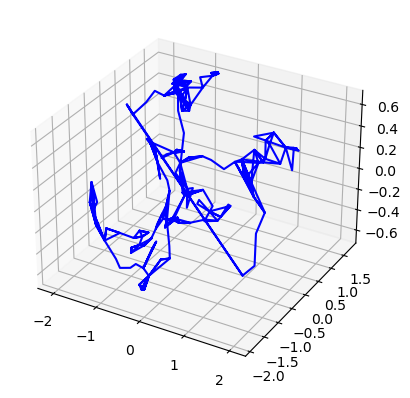

In [99]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_geodesic[:,0]
Y = torus_geodesic[:,1]
Z = torus_geodesic[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()